___

<center><h1>IMBD Classification Movie Reviews - DL</h1></center>

___

<center><h2>DSM0150 - Neural Networks</h2></center><br>
<center><strong>Teacher:</strong> Tim Blackwell</center>

___
<p></p>
<center style="color: #AA6373; font-weight: 400;"><strong>Presented by:</strong></center>
<center style="color: #AA6373; font-weight: 400;">Jorge Forero L.</center>
<center style="color: #AA6373; font-weight: 400;">Student Number: 240323983</center>
<center style="color: #AA6373; font-weight: 400;">Student Portal Username: JEFL1</center>
<center>March 2025</center>
<p></p>
___

## 1. Introduction & Problem Statement
<p></p>
This project aims to classify movie reviews in the IMDB dataset as positive or negative using a fully connected (Dense) neural network architecture constrained by Dropout layers, following the universal workflow in Deep Learning with Python (Part 1). By systematically analyzing textual data, tuning hyperparameters, and applying targeted regularization, we seek to identify the primary factors affecting sentiment classification accuracy and mitigate overfitting. Specifically, we investigate how different configurations of layers, units, dropout rates, optimizers, and batch sizes influence model performance, and we examine the extent to which early stopping and dropout help stabilize validation accuracy.

Through this process, we develop a robust predictive model that addresses three core questions: 
    - how architectural choices and parameter tuning impact accuracy
    - how dropout-based regularization reduces overfitting
    - how these findings can guide best practices for sentiment analysis using only Dense and Dropout layers.

The complete analysiswill be version-controlled and hosted on GitHub for easy access and collaboration. You can view and contribute to the project at the following URL: https://github.com/jforeroluque/DSM150_NeuralNetworks_CW1.

<p></p>


### Aims and Objectives
<p></p>
The primary aim of this project is to develop a high-performing sentiment classification model on the IMDB dataset, leveraging fully connected (Dense) layers and Dropout for regularization. We seek to accurately distinguish between positive and negative reviews while minimizing overfitting and maintaining model interpretability.
<p></p>

#### Objectives
<p></p>

1. Experiment with varying numbers of Dense layers, hidden units, dropout rates, and optimizers to strike an optimal balance between performance, generalizability, and training efficiency.
2. Identify both obvious and hidden patterns in the data using innovative visualization and clustering techniques to reveal insights into delivery risks.
3. Examine how Dropout (and possibly early stopping or other forms of regularization) can mitigate overfitting, ensuring that the model generalizes well to unseen data.
4. Compare the tuned model’s accuracy and loss metrics to a common-sense baseline (50% accuracy) and simpler architectures, evaluating the real impact of regularization and hyperparameter tuning.

<p></p>

#### Ethical Considerations
<p></p>

Transparency and Reproducibility
All steps of data preprocessing, model design, and hyperparameter tuning have been documented to ensure that others can replicate and validate the findings. Code and plots are presented in a notebook format for clarity and reproducibility.

For this Coursework we will be improving the results obtained in the previous one, where we got the following results:

Top 5 configurations:
Layers=3, Units=32, Dropout=0.5, Optimizer=adam, BatchSize=1024 -> val_acc=0.8910
Layers=2, Units=32, Dropout=0.2, Optimizer=rmsprop, BatchSize=1024 -> val_acc=0.8907
Layers=3, Units=16, Dropout=0.5, Optimizer=adam, BatchSize=512 -> val_acc=0.8904
Layers=2, Units=16, Dropout=0.2, Optimizer=adam, BatchSize=1024 -> val_acc=0.8892
Layers=2, Units=16, Dropout=0.5, Optimizer=rmsprop, BatchSize=512 -> val_acc=0.8891

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9733 - loss: 0.0830 - val_accuracy: 0.8851 - val_loss: 0.5093


In [27]:
# Common Modules

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## 2. Data Understanding [1]

In this phase, we collect, describe, and explore the IMDB movie review dataset to gain insights into its structure and primary attributes. The dataset includes 50,000 reviews, split evenly into training and test sets (25,000 each). Each review is presented as a sequence of word indices, representing the words and their frequencies in the movie review text. For our project, we focus on the top 10,000 most frequently used words to reduce sparsity and maintain manageable vector sizes. This IMDB data supports a quantitative evaluation of our hypotheses on how neural network architectures (specifically Dense and Dropout layers) can effectively classify sentiment, revealing which hyperparameters—such as the number of units, dropout rate, or optimizer—are most influential in achieving strong generalization performance.

### Limitations and constrains of the Data

While the IMDB dataset is a valuable resource for exploring sentiment classification, it presents several limitations and constraints that may influence our analysis and model performance:

1. Although we limit the vocabulary to the top 10,000 words for practical modeling, this approach can exclude less frequent but potentially significant words. As a result, some nuances in language usage may be lost, potentially leading to an oversimplified representation of the full sentiment space.
2. Converting each review into a multi-hot vector of word occurrences does not preserve word order or context. This simplification may limit the model’s ability to leverage sequence-based nuances (e.g., negation words or sarcasm), though this trade-off is acceptable under the constraints of using only Dense layers.

### Data Load

In [3]:
num_words = 10000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words) # Reference [2] page 95 DLWP

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))


Training samples: 25000
Test samples: 25000


### Exploratory Data Analysis

**Sequence Lenght Analysis**

Each review is a list of integers (word indices). We can look at how many words each review contains to understand the distribution of sequence lengths.

Minimum review length: 11
Maximum review length: 2494
Average review length: 238.71


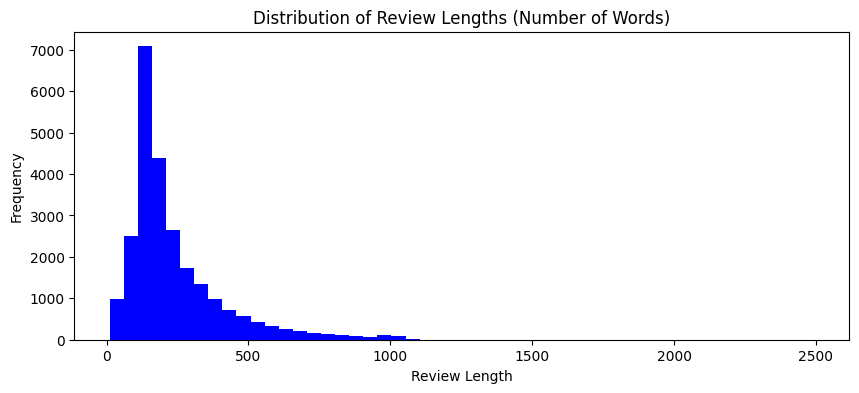

In [4]:
review_lengths = [len(sequence) for sequence in x_train]

print(f"Minimum review length: {np.min(review_lengths)}")
print(f"Maximum review length: {np.max(review_lengths)}")
print(f"Average review length: {np.mean(review_lengths):.2f}")

plt.figure(figsize=(10,4))
plt.hist(review_lengths, bins=50, color='blue')
plt.title("Distribution of Review Lengths (Number of Words)")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()

#### Data Preprocessing

Since we already did the model using only dense layers now we want to 
Since we are restricted to Dense layers, we will need to convert integer-encoded reviews to multi-hot vectors (or one-hot vectors) of shape (10000,). For this our approach will be the following:

In [5]:
maxlen = 500
x_train_padded = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_padded = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

## 3. Recurrent Neural Network Model

Here we will be building a model that uses an Embedding layer to learn a dense representation for words, we also will be applying a bidirectional LSTM to capture sequence dependencies from both directions

In [7]:
# RDD model architecture
model_rnn = keras.Sequential([
    layers.Embedding(input_dim=10000, output_dim=128),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.5)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Display model architecture
model_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Split into training & validation sets
x_val_rnn = x_train_padded[:10000]
partial_x_train_rnn = x_train_padded[10000:]
y_val_rnn = y_train[:10000]
partial_y_train_rnn = y_train[10000:]


In [13]:
#Model Training with Callbacks

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) # Reference [2] page 97 DLWP

history_rnn = model_rnn.fit(
    partial_x_train_rnn,
    partial_y_train_rnn,
    epochs=10,              
    batch_size=1024,
    validation_data=(x_val_rnn, y_val_rnn),
    callbacks=[early_stopping]
)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 135s 9s/step - accuracy: 0.5217 - loss: 0.6921 - val_accuracy: 0.6625 - val_loss: 0.6844
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 132s 9s/step - accuracy: 0.6257 - loss: 0.6666 - val_accuracy: 0.7534 - val_loss: 0.5430
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.7662 - loss: 0.5147 - val_accuracy: 0.8104 - val_loss: 0.4309
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.8335 - loss: 0.4124 - val_accuracy: 0.8215 - val_loss: 0.4197
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.8596 - loss: 0.3628 - val_accuracy: 0.8235 - val_loss: 0.4129
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.8745 - loss: 0.3351 - val_accuracy: 0.8270 - val_loss: 0.4165
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 146s 10s/step - accuracy: 0.8803 - loss: 0.3183 - val_accuracy: 0.8193 - val_loss: 0.4362


In [14]:
# Evaluating the model on test data

test_loss, test_acc = model_rnn.evaluate(x_test_padded, y_test)
print("Test accuracy:", test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.8240 - loss: 0.4197
Test accuracy: 0.8226799964904785


#### Plotting Training and Validation Metrics

In [15]:
history_dict = history_rnn.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

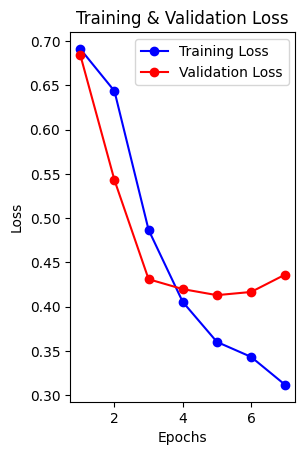

In [16]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [ ]:
# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Complex Model Development

Multi-Input Model with the Functional API

Here we add an extra input feature (the normalized review length) alongside the padded text sequences. This creates a multi-input network where one branch processes the text and another handles the extra feature. Batch Normalization layers are included to stabilize training.

In [17]:
# Parameters and Data Loading
maxlen = 500
num_words = 10000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

In [18]:
# Pad sequences for the recurrent network
x_train_padded = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_padded = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [19]:
# Create an extra feature: normalized review length (clipped to maxlen)
train_review_lengths = np.array([min(len(x), maxlen) for x in x_train]) / maxlen
test_review_lengths = np.array([min(len(x), maxlen) for x in x_test]) / maxlen

In [20]:
# Define inputs for text and extra features using the Functional API
input_text = keras.Input(shape=(maxlen,), name="input_text")
input_extra = keras.Input(shape=(1,), name="input_extra")

In [23]:
# Text branch: Embedding -> Bidirectional LSTM -> BatchNorm -> Dropout
x = layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen)(input_text)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
x = layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

In [21]:
# Extra branch: Dense layer for the review length feature
y = layers.Dense(16, activation='relu')(input_extra)
y = layers.BatchNormalization()(y)

In [24]:
# Concatenate the outputs from both branches and add further dense layers
combined = layers.concatenate([x, y])
z = layers.Dense(32, activation='relu')(combined)
z = layers.BatchNormalization()(z)
z = layers.Dropout(0.5)(z)
output = layers.Dense(1, activation='sigmoid')(z)

In [25]:
# Define and compile the multi-input model
model_multi = keras.Model(inputs=[input_text, input_extra], outputs=output)
model_multi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_multi.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 500, 128)  │  1,280,000 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 500, 128)  │     98,816 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64)        │     41,216 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_extra         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ bidirectional_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │         32 │ input_extra[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16)        │         64 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,592 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,423,137 (5.43 MB)

 Trainable params: 1,422,913 (5.43 MB)

 Non-trainable params: 224 (896.00 B)

In [28]:
# Set up callbacks: EarlyStopping and ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]


In [29]:
# Create validation splits (as in your original project)
x_val_text = x_train_padded[:10000]
x_val_extra = train_review_lengths[:10000]
partial_x_train_text = x_train_padded[10000:]
partial_x_train_extra = train_review_lengths[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [30]:
# Train the multi-input model
history_multi = model_multi.fit(
    {"input_text": partial_x_train_text, "input_extra": partial_x_train_extra},
    partial_y_train,
    epochs=10,
    batch_size=128,
    validation_data=(
        {"input_text": x_val_text, "input_extra": x_val_extra},
        y_val
    ),
    callbacks=callbacks
)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5286 - loss: 0.9269 

118/118 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5291 - loss: 0.9258 - val_accuracy: 0.7188 - val_loss: 0.6446
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7770 - loss: 0.4741

118/118 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7771 - loss: 0.4740 - val_accuracy: 0.8003 - val_loss: 0.4515
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.8615 - loss: 0.3437 - val_accuracy: 0.6774 - val_loss: 0.6463
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8146 - loss: 0.4225 - val_accuracy: 0.8035 - val_loss: 0.4554
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8809 - loss: 0.2992 - val_accuracy: 0.8033 - val_loss: 0.5058


In [31]:
# Evaluate the multi-input model on the test set
test_loss, test_acc = model_multi.evaluate(
    {"input_text": x_test_padded, "input_extra": test_review_lengths},
    y_test
)
print("Test accuracy (multi-input model):", test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.8027 - loss: 0.4513
Test accuracy (multi-input model): 0.7996799945831299
